# Image Processing Justification and Unit Test Script

- Justify chosen algorithm by comparing results obtained between different algorithms

- Perform unit testing on all functions to ensure they work as intended and produces the desired output (nodule detection, feature extraction, and preprocessing the CT scan stack before inputting into the CNN model)

In [1]:
# Import necessary modules and packages
import os
import numpy as np
import pydicom
import cv2
import PIL
import math
import matplotlib.pyplot as plt
from matplotlib import cm
from glob import glob
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from skimage import segmentation
from sklearn.cluster import KMeans

Loading data (all ct scan slices) from patient with id=0001

In [2]:
data_path = "/home/student/Documents/FYP/LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-30178/3000566.000000-03192"
output_path = working_path = "/home/student/Documents/FYP/ip/output"
g = glob(data_path + '/*.dcm')

Load all scans into list and converts raw values into Houndsfeld units

In [3]:
def load_scan(path):
    
    scans = []
    for pth, dirs, files in os.walk(path):
        for filename in files:
            if ".dcm" in filename: 
                scans.append(os.path.join(pth,filename))
        
    slices = [pydicom.read_file(s) for s in scans]
    
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

# Unit test 1 and 2:

- Test functionality of load_scan, get_pixels_hu, sample_stack
- To show that they work as expected, sample stack is displayed
- Tested for case in which stack is empty, error message returned correctly

Display stack of ct scans (for user-friendly purposes, just display every 3rd slice)

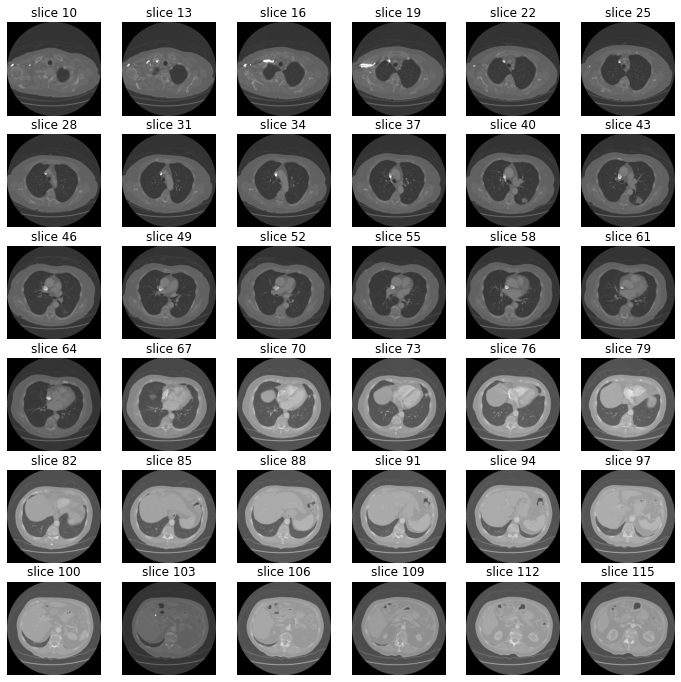

In [4]:
id = 0
imgs_to_process = np.load(output_path+'output{}.npy'.format(id))

def sample_stack(stack, rows=6, cols=6, start_with=10, show_every=3):
    
    if len(stack) > 0:
        fig,ax = plt.subplots(rows,cols,figsize=[12,12])
        for i in range(rows*cols):
            ind = start_with + i*show_every
            ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
            ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
            ax[int(i/rows),int(i % rows)].axis('off')
        plt.show()
    else:
        print("Stack is empty")
        
patient = load_scan(data_path)
imgs = get_pixels_hu(patient)
sample_stack(imgs_to_process)

In [5]:
sample_stack([])

Stack is empty


# Justification 1

- Function to apply median filter onto image (filtering and removing white noise). 
- median filter is chosen because it is an edge preserving algorithm 
- (research shows that edge preserving algorithms perform better in nodule detection as opposed to non-edge preserving algorithms such as gaussian blur)

In [6]:
# median filter
def median_filter(img, display=False, footprint=0):
    temp = scipy.ndimage.median_filter(img,2)
    if (display):
        plt.axis('off')
        plt.imshow(temp,cmap='gray')
    return temp

# Justification 2

Function used to perform the segmentation algorithm on the CT scan.
Segmentation is used to segment the image and remove all blood vessels and noise, leaving only the lung cavity
and nodules behind.
Segmentation algorithm is done by: 
- Standardize the pixel value by subtracting the mean and dividing by the standard deviation
- Identify the proper threshold by creating 2 KMeans clusters comparing centered on soft tissue/bone vs lung/air.
- Using Erosion and Dilation which has the net effect of removing tiny features like pulmonary vessels or noise

This region growing thresholding algorithm is developed by piecing together different pipelines and code segments from multiple proposed algorithms. The reason why this algorithm is chosen is because after testing, it seems to yield adequate and accurate results. Region growing and thresholding segmentation algorithms are commonly used in nodule detection algorithms in this field. For the purposes of nodule detection, it has repeatedly shown to generate highly satisfactory results. As can be seen in the unit test below, after median filter and segmentation is performed, all white noise and any unwanted parts of the lung (aside from the lung wall and any existing nodule) is removed.

In [7]:
# Segmentation and thresholding
def thresholding(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    #
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))
    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))
    
    if display:
        plt.imshow(dilation, cmap='gray')
        
    else:
        return dilation

# Unit test 3:

- Test median filter and thresholding function 
- it can be seen that the resulting output is the desired expected outcome

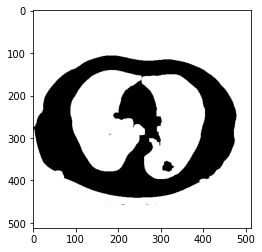

In [8]:
img = imgs_to_process[44]
thresholding(median_filter(img), True)


# Justification 3:

- Comparison is done among various segmentation algorithms for edge detetion purposes (segmentation, superpixel and morphological algorithms)
- Justification of why ACWE morphological evolution algorithm was chosen.
- Firstly, display original CT scan with just minimal median filter applied (test on slice 44, which has nodule on bottom right corner) for comparison with algorithm results later

array([[-2048, -2048, -2048, ..., -2048, -2048, -2048],
       [-2048, -2048, -2048, ..., -2048, -2048, -2048],
       [-2048, -2048, -2048, ..., -2048, -2048, -2048],
       ...,
       [-2048, -2048, -2048, ..., -2048, -2048, -2048],
       [-2048, -2048, -2048, ..., -2048, -2048, -2048],
       [-2048, -2048, -2048, ..., -2048, -2048, -2048]], dtype=int16)

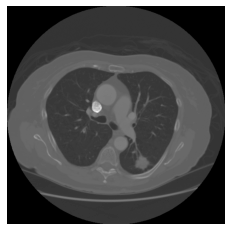

In [9]:
img = imgs_to_process[44]
median_filter(img, display=True)

# Comparison of segmentation algorithms is divided into two parts (test is done on the same slice as shown above, above slice acts as a control).
- comparison between superpixel "oversegmentation" algorithms 
- comparison between morphological segmentation algorithms
 
The example below compares four popular superpixel oversegmentation algorithms to justify the reason why they were not chosen. Oversegmentation algorithms are widely use in image processing because it increases the probability that boundaries of importance have been extracte, but this runs the risk of creating many insignificant boundaries along the way. This is shown in the example below in which the oversegmentation even segments the lung wall. Thus, the oversensitivity of these algorithms are not ideal for purposes of our topic. 

Superpixel algorithms compared are:
- Felzenszwalb’s efficient graph based segmentation (extremely fast processing time)
- Quickshift image segmentation
- SLIC - K-Means based image segmentation (extremely efficient)
- Compact watershed segmentation of gradient image

Felzenszwalb number of segments: 84
SLIC number of segments: 10
Quickshift number of segments: 276


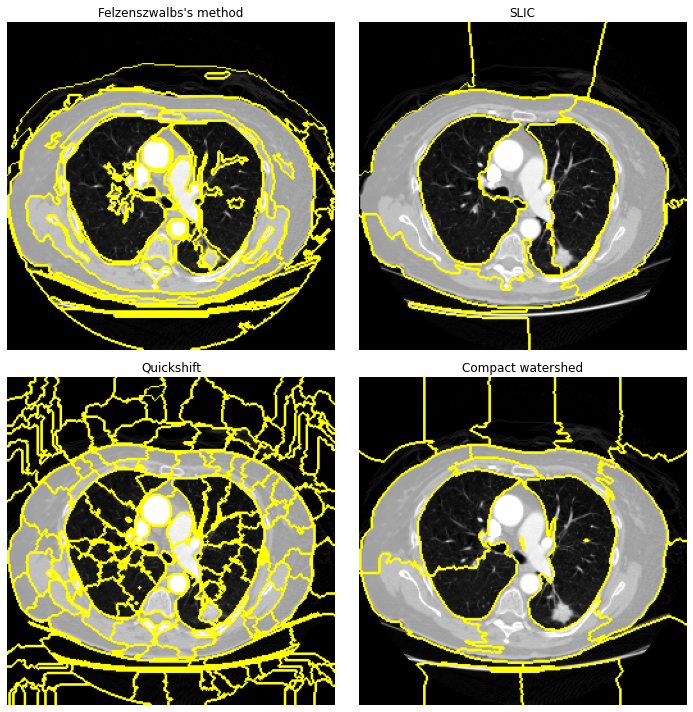

In [10]:
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import mark_boundaries
from skimage import img_as_float

img = imgs_to_process[44]

# normalise image because slice is originally a 2D slice, but these algorithms only work on RGB images, so 
# rgb channels are obtained an image is resized
def get_rgb_channel(image):
    MIN_BOUND = -1000.0
    MAX_BOUND = 400.0
    image2 = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image2[image2>1] = 1.
    image2[image2<0] = 0.
    return image2

new = get_rgb_channel(img)
img = cv2.resize(np.array(new),(512,512))    
rgb = np.stack((img,)*3, axis=-1)
img = img_as_float(rgb[::2, ::2])

segments_fz = segmentation.felzenszwalb(img, scale=250, sigma=0.5, min_size=50)
segments_slic = segmentation.slic(img, n_segments=15, compactness=10, sigma=1)
segments_quick = segmentation.quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(img))
segments_watershed = segmentation.watershed(gradient, markers=25, compactness=0.001)

print(f"Felzenszwalb number of segments: {len(np.unique(segments_fz))}")
print(f"SLIC number of segments: {len(np.unique(segments_slic))}")
print(f"Quickshift number of segments: {len(np.unique(segments_quick))}")

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(img, segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(img, segments_slic))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(img, segments_quick))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(img, segments_watershed))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

# Comparison between morphological edge detection algorithms
- Perform and compare between morphological algorithms. 
- Compare between ACWE and GAC morphological algorithms.
- for each ACWE and GAC algorithms, compare between doing the segmentation once, and doing it in evolution

After performing filtering (using median_filter) and thresholding segmentation, feed the resulting image into the morphological function to compare the results. It can be seen that morphological ACWE evolution performs the best. It is able to detect that there is a separate nodule from the lung, and it successfully detects the lung as one whole region. Although morphological algorithms take a longer time to process and tend to be less sensitive to segment possibilities, the reduce in sensitivity is useful and advantageous for the purposes of nodule detection which is why they are commonly used for this reason. Hence, the morphological ACWE evolution edge detection algorithm is chosen.

- Advantage: More accurate result
- Disadvantage: Requires longer processing time

In [11]:
def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store


def morph(img):
    
    # Morphological ACWE
    # Initial level set
    init_ls = segmentation.checkerboard_level_set(img.shape, 6)
    # List with intermediate results for plotting the evolution
    evolution = []
    callback = store_evolution_in(evolution)
    ls = segmentation.morphological_chan_vese(img, 35, init_level_set=init_ls, smoothing=3,
                                 iter_callback=callback)

    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    ax = axes.flatten()

    ax[0].imshow(img, cmap="gray")
    ax[0].set_axis_off()
    ax[0].contour(ls, [0.5], colors='r')
    ax[0].set_title("Morphological ACWE segmentation", fontsize=12)

    ax[1].imshow(ls, cmap="gray")
    ax[1].set_axis_off()
    contour = ax[1].contour(evolution[2], [0.5], colors='g')
    contour.collections[0].set_label("Iteration 2")
    contour = ax[1].contour(evolution[7], [0.5], colors='y')
    contour.collections[0].set_label("Iteration 7")
    contour = ax[1].contour(evolution[-1], [0.5], colors='r')
    contour.collections[0].set_label("Iteration 35")
    ax[1].legend(loc="upper right")
    title = "Morphological ACWE evolution"
    ax[1].set_title(title, fontsize=12)

    # Morphological GAC
    gimage = segmentation.inverse_gaussian_gradient(img)

    # Initial level set
    init_ls = np.zeros(img.shape, dtype=np.int8)
    init_ls[10:-10, 10:-10] = 1
    # List with intermediate results for plotting the evolution
    evolution = []
    callback = store_evolution_in(evolution)
    ls = segmentation.morphological_geodesic_active_contour(gimage, 230, init_ls,
                                               smoothing=1, balloon=-1,
                                               threshold=0.69,
                                               iter_callback=callback)

    ax[2].imshow(img, cmap="gray")
    ax[2].set_axis_off()
    ax[2].contour(ls, [0.5], colors='r')
    ax[2].set_title("Morphological GAC segmentation", fontsize=12)

    ax[3].imshow(ls, cmap="gray")
    ax[3].set_axis_off()
    contour = ax[3].contour(evolution[0], [0.5], colors='g')
    contour.collections[0].set_label("Iteration 0")
    contour = ax[3].contour(evolution[100], [0.5], colors='y')
    contour.collections[0].set_label("Iteration 100")
    contour = ax[3].contour(evolution[-1], [0.5], colors='r')
    contour.collections[0].set_label("Iteration 230")
    ax[3].legend(loc="upper right")
    title = "Morphological GAC evolution"
    ax[3].set_title(title, fontsize=12)

    fig.tight_layout()
    plt.show()

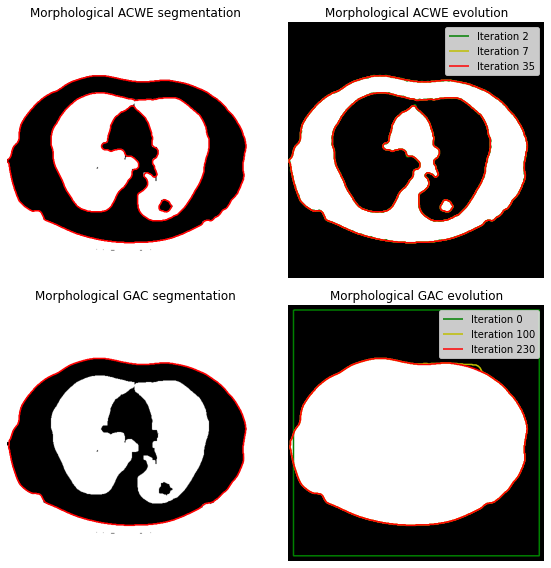

In [12]:
img = imgs_to_process[44]
morph(thresholding(median_filter(img)))

# Unit test 4
Function used for morphological ACWE evolution, returns just the contour line of the feature found (that is obtained from doing the segmentation)

In [13]:
def acwe_morph(img, display=False):
    
    init_ls = segmentation.checkerboard_level_set(img.shape, 6)
    evolution = []
    callback = store_evolution_in(evolution)
    ls = segmentation.morphological_chan_vese(img, 35, init_level_set=init_ls, smoothing=3,
                                 iter_callback=callback)

    if display: 
        plt.axis('off')
        plt.imshow(ls, cmap="gray")
        contour = plt.contour(evolution[2], [0.5], colors='g')
        contour.collections[0].set_label("Iteration 2")
        contour = plt.contour(evolution[7], [0.5], colors='y')
        contour.collections[0].set_label("Iteration 7")
        contour = plt.contour(evolution[-1], [0.5], colors='r')
        contour.collections[0].set_label("Iteration 35")
        
    return ls
    

Test the acwe morph function using the same test slice from the previous example (slice 44), perform median_filter and thresholding on it, and feed this resulting image into the morphological ACWE evolution function. Then, take the contour line obtained from the ACWE and plot is as a mask over the original ct scan image to check if its correct. As can be seen, it successfully detects the lung segment and nodule. Result is outputted as expected.

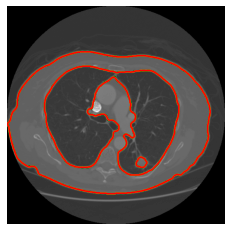

In [14]:
second_img = imgs_to_process[44]
acwe_morph(thresholding(median_filter(second_img)), True)

plt.axis('off')
plt.imshow(second_img,cmap='gray')

Function used to obtain only the nodules (without the lung cavity) from a scan. After performing the ACWE morphological evolution algorithms, label the different regions of the image, and remove the region of the image that is the lung segment (the lung wall). To remove the lungs cavity, we have to remove the largest surrouding region (because the largest region is the lung wall segment). For each remaining region, extract its features such as area, diameter, solidity and its spiculation. Return the labelled image without the lung wall segment (only getting nodules in the lung), and return the extracted features

In [15]:
def get_nodule(img, display=False, explain=False):
    second_img = img
    second_img = acwe_morph(thresholding(median_filter(second_img)))

    label_img = measure.label(second_img)
    regions = measure.regionprops(label_img)

    if display:
        fig, ax = plt.subplots()
        ax.imshow(label_img)

    im_border = segmentation.clear_border(second_img, buffer_size=5)
    
    if display:
        plt.imshow(im_border)

    label_img = measure.label(im_border)
    regions = measure.regionprops(im_border)
    
    for props in regions:
        equivalent_diameter = props.equivalent_diameter*0.2645833333
        diameter = props.major_axis_length*0.2645833333
        if display:
            print("Area of nodule is (mm^2)" ,props.area*0.2645833333*0.2645833333, "\nDiameter of nodule is (mm)",diameter)
            print("solidity: ", props.solidity)
            print("spiculation: ", diameter-equivalent_diameter)
        if explain:
            spiky = diameter-equivalent_diameter
            area, diam, solid = props.area*0.2645833333*0.2645833333, diameter, props.solidity
            return im_border, area, diam, solid, spiky
            
    
    return im_border

Function used to highlight the nodule found on the original CT scan (for user friendly purposes, easier for the user to see which part of the lung is the detected nodule)

In [16]:
def show_nodules(img, new_img, display=True): 
    
    contours = measure.find_contours(new_img, 0.8)
    
    fig, ax = plt.subplots()
    ax.imshow(img, cmap=plt.cm.gray)

    for n, contour in enumerate(contours):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1.5, color='red')
    
    if display:
        ax.set_xticks([])
        ax.set_yticks([])
        plt.show()
    else:
        return plt

# Unit test 5
Test functionality of get_nodule function and show_nodules function
Using the same example (slice 44) as before, find the nodule in the ct scan (removing the lung cavity and all other white noise such as tissue and vessels), and extract its features. Display the features details. From the nodule found, find the contour and plot this contour as a mask over the original image to highlight the nodule in the original ct scan
It can be seen that the nodule is successfully detected, with the lung region removed leaving only the nodule behind. The features of the nodule are also successfully extracted. Thus, functionality of get_nodule function is working as expected.
In the next slice, the nodule found is successfully highlighted on the original CT scan slice. Thus, functionality of show_nodule is correct and output is as expected

Area of nodule is (mm^2) 30.241874992379998 
Diameter of nodule is (mm) 6.308784514950183
solidity:  0.9664429530201343
spiculation:  0.10353261456486429


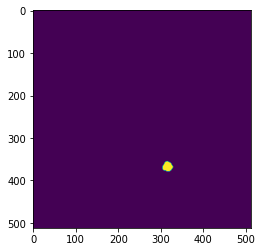

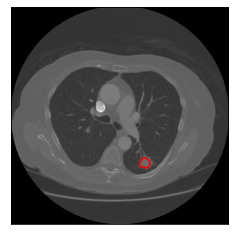

In [17]:
img = imgs_to_process[44]
new_img = get_nodule(img, True)
show_nodules(img, new_img)

Function used to preprocess a single scan for the purposes of the CNN. Preprocess the scan such that it will remove the lung and only return regions of the image that are determined to be nodules (size smaller than 20000 pixels and has solidity of >0.9). For every region found (in the case that there is more than one nodule) that meets this criteria, obtain the coordinates of this region, and keep the maximum x,y and minimum x,y coordinates of the region.

In [18]:
def cnn_process(second_img, display=False):
    
    label_img = measure.label(second_img)
    regions = measure.regionprops(label_img)

    if display:
        fig, ax = plt.subplots()
        ax.imshow(label_img)

    im_border = segmentation.clear_border(second_img, buffer_size=5)
    
    if display:
        plt.imshow(im_border)

    label_img = measure.label(im_border)
    regions = measure.regionprops(im_border)
    
    area_coords = []
    
    for props in regions:
        if 0 < props.area < 20000 and props.solidity > 0.90:
            area_coords.append(props.coords.tolist())
    
    result = []
       
    for nodule in area_coords:
        max_x = nodule[0][0]
        min_x = nodule[0][0]
        max_y = nodule[0][1]
        min_y = nodule[0][1]

        for x,y in nodule:
            if x < min_x:
                min_x = x
            if x > max_x:
                max_x = x
            if y < min_y:
                min_y = y
            if y > max_y:
                max_y = y
        result.append([max_x, min_x, max_y, min_y])
        
        if display:
            print(max_x, min_x, max_y, min_y)

    
    return result

# Unit test 6

Test the cnn_process function to see that it successfully returns the coordinates of a nodule if it is found within a slice. To accuractely test the functionality, it is run on a single slice first to examine the output.

Testing on a single slice (same as previous example), the max x,y and min x,y coordinates of the region (nodule) found is as shown below.

Thus, the result is as expected and function is working correctly.

378 355 328 304


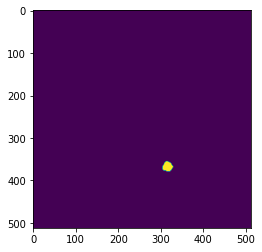

In [19]:
img = imgs_to_process[44]
second_img = acwe_morph(thresholding(median_filter(img)))
result = cnn_process(second_img, True)
max_y = result[0][0]
min_y = result[0][1]
max_x = result[0][2]
min_x = result[0][3]

Check if the coordinates returned are accurate by cropping the original slice accordingly an observing the result.

From the previously found feature coordinates, add padding for top and bottom as well and left and right, and then crop the original ct scan to these coordinates in order to obtain the input for the cnn (CT scan with just the zoomed in nodule, and without the other parts of the lung, in order to closely resemble the training data)

The result shown below shows that the coordinates obtained were accurate

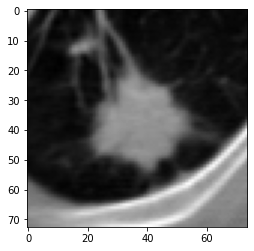

In [20]:
img = imgs_to_process[44]
plt.imshow((img[min_y - 25 :max_y + 25, min_x - 25:max_x +25]),cmap=plt.cm.gray)

Since it is proven to work on a single slice, scale it up and create helper function to process all the coordinates for every nodule found in a slice

In [21]:
def get_nodule_stack(nodule_coords, img):
    
    img_stack = []
    
    for max_y, min_y, max_x, min_x in nodule_coords:
        
        pad_up = 25 
        pad_down = 25
        pad_left = 25 
        pad_right = 25 
        
        img_stack.append(median_filter(img[min_y - pad_down :max_y + pad_up, min_x - pad_up:max_x +pad_right], False, 1))    
    
    return img_stack

Now, to preprocess the whole stack of CT scans of the single patient (for the cnn input and for displaying in the webapp). Use the same algorithm and flow as before, just that it is now looping through the whole stack. This whole process takes a while (~3-5 minutes). 
Returns only the zoomed-in slices with nodules found, along with its original CT scan

In [22]:
def get_all(imgs_after_resamp):   
    all_nodule_slices = []
    only_nodule_slices = []

    for img in imgs_after_resamp[15:]:
        second_img = acwe_morph(thresholding(median_filter(img)))
        all_nodule_slices.append(second_img)
        nodule_coords = cnn_process(second_img) 
        if len(nodule_coords) > 0:
            img_stack = get_nodule_stack(nodule_coords, img)
            for image in img_stack:
                only_nodule_slices.append([image, img])
                
    return only_nodule_slices

In [23]:
only_nodule_slices = get_all(imgs_to_process)

# Unit test 7

To check that the helper function worked correctly and is able to run on the entire stack, display the results when the entire algorithm is run on the whole stack instead of a single slice.

Display all the zoomed-in nodule slices found in the stack and display how many nodule slices are found

The displayed results below shows that the function worked as expected and produced the desired output

5


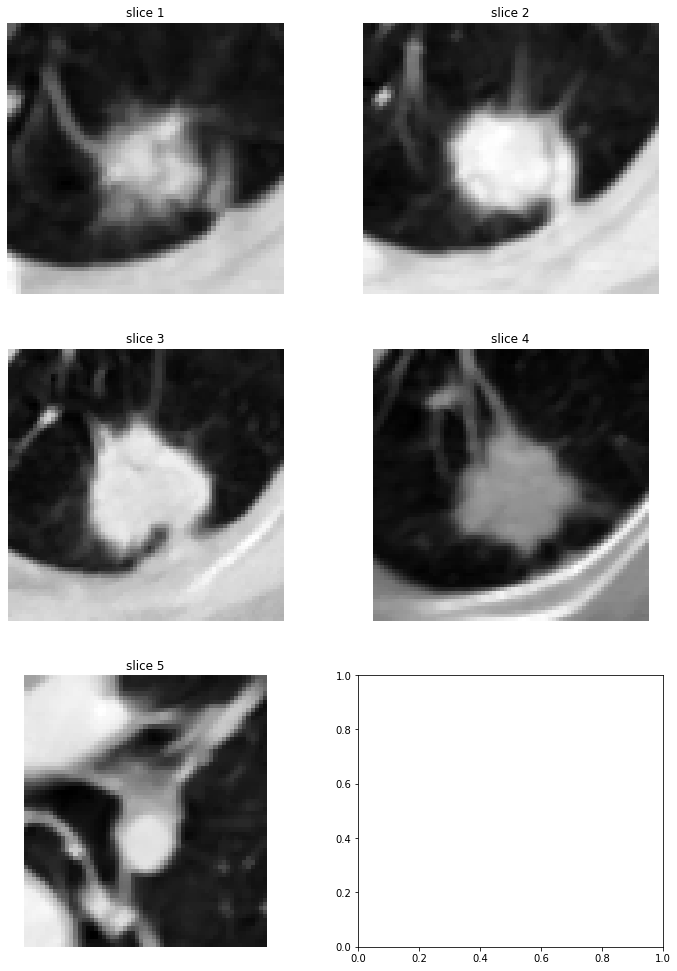

In [24]:
def sample_stack(stack, rows=2):
    size = len(stack)
    if size % 2 == 0:
        cols = size//2
    else: 
        cols = size//2 + 1
    fig,ax = plt.subplots(cols, rows, figsize=[12,17])
    for i in range(rows*cols):
        if i < size:
            ax[int(i/rows),int(i % rows)].set_title('slice %d' % (i+1))
            ax[int(i/rows),int(i % rows)].imshow(stack[i][0],cmap='gray')
            ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

print(len(only_nodule_slices))
sample_stack(only_nodule_slices)

For every slice with a nodule found, display the zoomed-in slice with its original CT scan

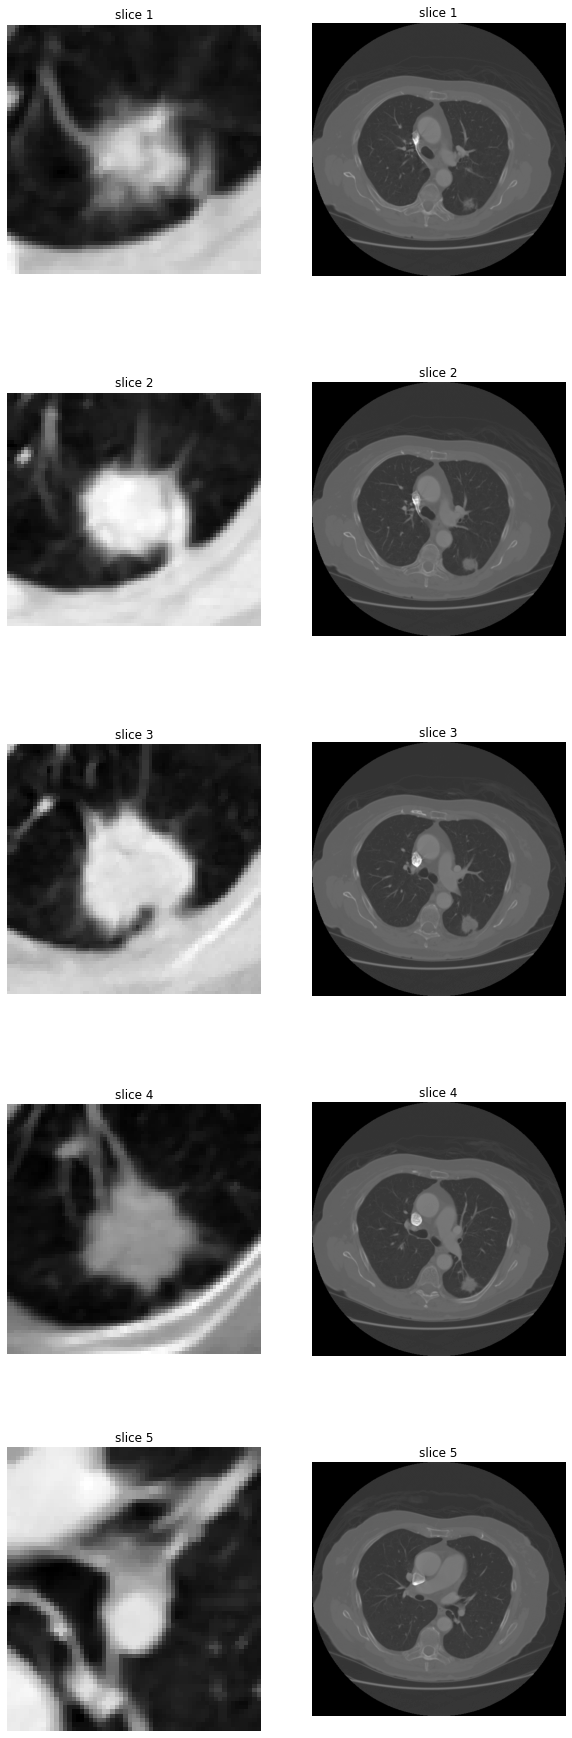

In [25]:
def sample_stack(stack, rows=2):
    
    size = len(stack)

    fig,ax = plt.subplots(size, rows, figsize=[10,32])
    for i in range(size):
        ax[i,0].set_title('slice %d' % (i+1))
        ax[i,0].imshow(stack[i][0],cmap='gray')
        ax[i,0].axis('off')
        
        ax[i,1].set_title('slice %d' % (i+1))
        ax[i,1].imshow(stack[i][1],cmap='gray')
        ax[i,1].axis('off')
        
    plt.show()

sample_stack(only_nodule_slices)

For every slice with a nodule found, display the zoomed-in nodule and the original CT scan, but with the nodule highlighted. This is done by using the previous functions (segmentaion and morphological algorithms)

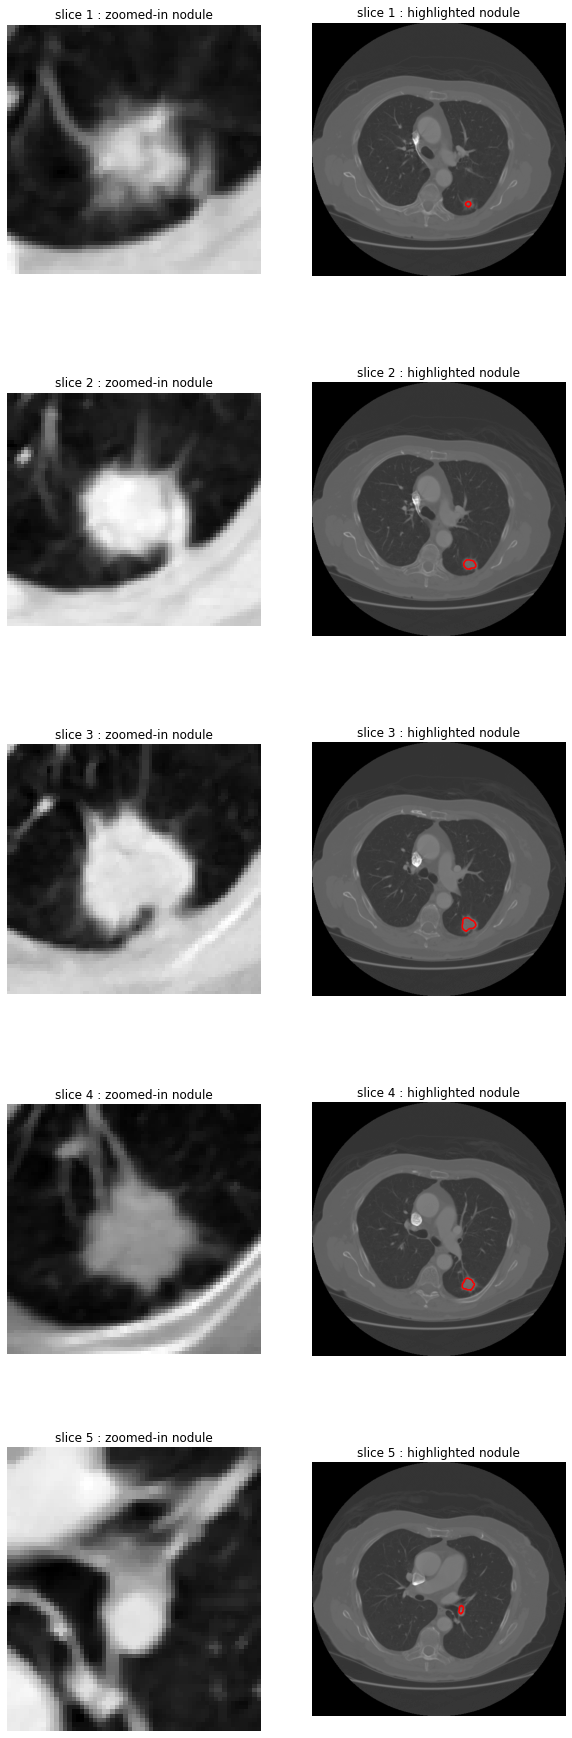

In [26]:
def sample_stack(stack, rows=2):
    
    size = len(stack)

    fig,ax = plt.subplots(size, rows, figsize=[10,32])
    for i in range(size):
        ax[i,0].set_title('slice %d : zoomed-in nodule' % (i+1))
        ax[i,0].imshow(stack[i][0],cmap='gray')
        ax[i,0].axis('off')
        
        new_img = get_nodule(stack[i][1], False)
        contours = measure.find_contours(new_img, 0.8)
        
        ax[i,1].set_title('slice %d : highlighted nodule' % (i+1))
        ax[i,1].imshow(stack[i][1],cmap='gray')
        ax[i,1].axis('off')
        
        for n, contour in enumerate(contours):
            ax[i,1].plot(contour[:, 1], contour[:, 0], linewidth=1.5, color='red')
        
    plt.show()

sample_stack(only_nodule_slices)

Create rule based system, based on the nodule found in the slice, extract the nodule's features from its original image (to preserve its true size and features), and display them. Based on the extracted features, speculate if its malignant or benign

In [27]:
def rule_based(img, i):
    
    zoomed_in = img[0]
    original = img[1]
    
    fig,ax = plt.subplots(1, 2, figsize=[10,40])
    
    ax[0].set_title('slice %d : zoomed-in nodule' % (i+1))
    ax[0].imshow(zoomed_in,cmap='gray')
    ax[0].axis('off')

    new_img, area, diameter, solidity, spiculation= get_nodule(original, False, True)
    contours = measure.find_contours(new_img, 0.8)

    ax[1].set_title('slice %d : highlighted nodule' % (i+1))
    ax[1].imshow(original,cmap='gray')
    ax[1].axis('off')

    for n, contour in enumerate(contours):
        ax[1].plot(contour[:, 1], contour[:, 0], linewidth=1.5, color='red')
        
    plt.show()
    
    if diameter >= 3 and spiculation > 0.1:
        print("Nodule is strongly speculated to be malignant because diameter of nodule >=3mm and its spiculation is spiky")
    else:
        if diameter<3:
            print("Nodule may be malignant because its spiculation is spiky but diameter is <3mm")
        else:
            print("Nodule may be malignant because its diamter is >=3mm but its spiculation is not spiky")
    
    print("Area of Nodule:", area)
    print("Diameter of Nodule:", diameter)
    print("Solidity of Nodule:", solidity)
    print("Spiculation:", spiculation)
    

# Unit test 8

- test the functionality of the rule-based function
- it can be seen that the desired output is produced and an assumption is able to be produced
- the details of the nodule are successfully displayed
- thus, rule-base function works as expected

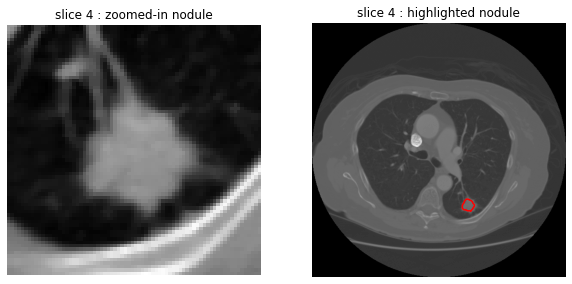

Nodule is strongly speculated to be malignant because diameter of nodule >=3mm and its spiculation is spiky
Area of Nodule: 30.591896693680695
Diameter of Nodule: 6.344841652714308
Solidity of Nodule: 0.9604395604395605
Spiculation: 0.10378303907774455


In [28]:
rule_based(only_nodule_slices[3], 3)